# Active Inference cadCAD model

This notebook explores multi-agent active inference simulations by representing agents as nodes on a graph.

## cadCAD Standard Notebook Layout

### 0. Dependencies

In [ ]:
import pandas as pd
import numpy as np
from random import normalvariate, random
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from radcad import Model, Simulation, Experiment

from pymdp.control import construct_policies
from pymdp.maths import softmax

# Additional dependencies

# For networks
import networkx as nx
# For visualization
from matplotlib import pyplot as plt
import plotly.express as px
import hvplot.networkx as hvnx
import holoviews as hv
hv.extension('bokeh')

# For analytics
import itertools

# local utils
import utils as u
import random as rand

from blockference.gridference import ActiveGridference

### Initializing Agent Network

In [25]:
grid = list(itertools.product(range(10), repeat=2))
print(grid[grid.index((0,0))])

(0, 0)


In [3]:
# Generate an empty directional graph
G = nx.MultiDiGraph()

# Number of agents
NUMBER_AGENTS = 10

for a in range(NUMBER_AGENTS):
    # create new agent
    agent = ActiveGridference(grid)
    # generate target state
    target = (rand.randint(0,9), rand.randint(0,9))
    # add target state
    agent.get_C(target)
    # all agents start in the same position
    agent.get_D((0, 0))

    # Add agent to the graph
    G.add_node(a, agent=agent, prior_A=softmax(agent.A), prior_B=agent.B, prior_C=agent.C,
               prior=softmax(agent.D), env_state=grid[0], action='', current_inference='')

print("agents_network:")
print(G.nodes(data=True))

agents_network:
[(0, {'agent': <model.ActiveGridference object at 0x12952cd90>, 'prior_A': array([[0.02672363, 0.00983107, 0.00983107, ..., 0.00983107, 0.00983107,
        0.00983107],
       [0.00983107, 0.02672363, 0.00983107, ..., 0.00983107, 0.00983107,
        0.00983107],
       [0.00983107, 0.00983107, 0.02672363, ..., 0.00983107, 0.00983107,
        0.00983107],
       ...,
       [0.00983107, 0.00983107, 0.00983107, ..., 0.02672363, 0.00983107,
        0.00983107],
       [0.00983107, 0.00983107, 0.00983107, ..., 0.00983107, 0.02672363,
        0.00983107],
       [0.00983107, 0.00983107, 0.00983107, ..., 0.00983107, 0.00983107,
        0.02672363]]), 'prior_B': array([[[1., 0., 1., 0., 1.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0.],
        ...,
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 1.],
        [0., 0., 1., 0., 0.],
        ...,
        [0., 0., 0., 0

### 1. State Variables

In [4]:
initial_state = {
    'agents_network': G
}

### 2. System Parameters

In [5]:
params = {}

### 3. Policy Functions

- `get_observation`
- `infer_states`
- `calc_efe`
- `calc_action_posterior`
- `sample_action`
- `calc_next_prior`
- `update_env_state`

In [6]:
def p_actinf(params, substep, state_history, previous_state):
    # State Variables
    graph = previous_state['agents_network']

    # list of all updates to the agents in the network
    agent_updates = []

    for agent in graph.nodes:

        policies = construct_policies([graph.nodes[agent]['agent'].n_states], [len(graph.nodes[agent]['agent'].E)], policy_len = graph.nodes[agent]['agent'].policy_len)
        # get obs_idx
        obs_idx = grid.index(graph.nodes[agent]['env_state'])

        # infer_states
        qs_current = u.infer_states(obs_idx, graph.nodes[agent]['prior_A'], graph.nodes[agent]['prior'])

        # calc efe
        _G = u.calculate_G_policies(graph.nodes[agent]['prior_A'], graph.nodes[agent]['prior_B'], graph.nodes[agent]['prior_C'], qs_current, policies=policies)

        # calc action posterior
        Q_pi = u.softmax(-_G)
        # compute the probability of each action
        P_u = u.compute_prob_actions(graph.nodes[agent]['agent'].E, policies, Q_pi)
        
        # sample action
        chosen_action = u.sample(P_u)

        # calc next prior
        prior = graph.nodes[agent]['prior_B'][:,:,chosen_action].dot(qs_current) 

        # update env state
        # action_label = params['actions'][chosen_action]

        (Y, X) = graph.nodes[agent]['env_state']
        Y_new = Y
        X_new = X
        # here

        if chosen_action == 0: # UP
            
            Y_new = Y - 1 if Y > 0 else Y
            X_new = X

        elif chosen_action == 1: # DOWN

            Y_new = Y + 1 if Y < graph.nodes[agent]['agent'].border else Y
            X_new = X

        elif chosen_action == 2: # LEFT
            Y_new = Y
            X_new = X - 1 if X > 0 else X

        elif chosen_action == 3: # RIGHT
            Y_new = Y
            X_new = X +1 if X < graph.nodes[agent]['agent'].border else X

        elif chosen_action == 4: # STAY
            Y_new, X_new = Y, X 
            
        current_state = (Y_new, X_new) # store the new grid location
        agent_update = {'source': agent,
                        'update_prior': prior,
                        'update_env': current_state,
                        'update_action': chosen_action,
                        'update_inference': qs_current}
        agent_updates.append(agent_update)

    return {'agent_updates': agent_updates}

### 4. State Update Functions

In [7]:
def s_agents_network(params, substep, state_history, previous_state, policy_input):
    # State Variables
    G_new = previous_state['agents_network'].copy()

    agent_updates = policy_input['agent_updates']

    if agent_updates != []:
        for update in agent_updates:
            source = update['source']
            update_prior = update['update_prior']
            update_env = update['update_env']
            update_action = update['update_action']
            update_inference = update['update_inference']
            # print(G_new.nodes[source])

            G_new.nodes[source]['prior'] = update_prior
            G_new.nodes[source]['env_state'] = update_env
            G_new.nodes[source]['action'] = update_action
            G_new.nodes[source]['current_inference'] = update_inference
    return ('agents_network', G_new)

### 5. Partial State Update Blocks

In [8]:
state_update_blocks = [
    {
        'policies': {
            'p_actinf': p_actinf
        },
        'variables': {
            'agents_network': s_agents_network
        }
    }
]

### 6. Configuration

In [9]:
model = Model(
    # Model initial state
    initial_state=initial_state,
    # Model Partial State Update Blocks
    state_update_blocks=state_update_blocks,
    # System Parameters
    params=params
)

### 7. Execution

In [64]:
simulation = Simulation(
    model=model,
    timesteps=1000,  # Number of timesteps
    runs=1  # Number of Monte Carlo Runs
)

In [65]:
result = simulation.run()

### 8. Analysis

In [16]:
pd.options.plotting.backend = "plotly"

In [66]:
df = pd.DataFrame(result)
df

,agents_network,simulation,subset,run,substep,timestep
0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,0,0
1,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,1
2,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,2
3,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,3
4,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,4
...,...,...,...,...,...,...
996,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,996
997,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,997
998,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,998
999,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",0,0,1,1,999


In [68]:
print(np.where(G.nodes[1]['prior_C']==1)[0][0])
grid[np.where(G.nodes[1]['prior_C']==1)[0][0]]

31


(3, 1)

In [61]:
def plot_network(timestep):
    # Get the agents network at the beginning
    G = df.agents_network.iloc[timestep]

    # Get the agent states
    node_balances = nx.get_node_attributes(G,'env_state')
    node_labels = {node: f"{value}"
                for node, value
                in node_balances.items()}

    # Node sizes
    sizes = [grid.index(value) for value in list(node_balances.values())]

    # Prepare the figure
    plt.figure(figsize=(12, 4))

    # Draw the nodes
    pos = nx.spring_layout(G)
    nx.draw(G,
            pos,
            node_size=sizes)

    # Draw the balances
    nx.draw_networkx_labels(G, pos, labels=node_labels)

    # Get the agent states
    node_balances2 = nx.get_node_attributes(G,'prior_C')
    node_labels2 = {node: f"{grid[np.where(value==1)[0][0]]}"
                for node, value
                in node_balances2.items()}

    # Node sizes
    sizes2 = [1 for value in list(node_balances.values())]

    # Prepare the figure
    plt.figure(figsize=(12, 4))

    # Draw the nodes
    pos2 = nx.spring_layout(G)
    nx.draw(G,
            pos2,
            node_size=sizes2)

    # Draw the balances
    nx.draw_networkx_labels(G, pos2, labels=node_labels2)

    # Show the visualization
    plt.show()

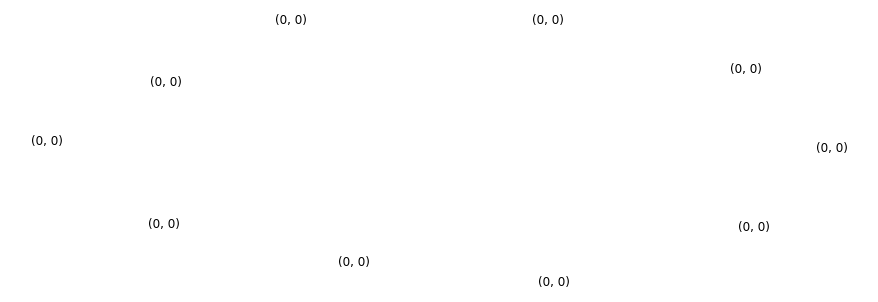

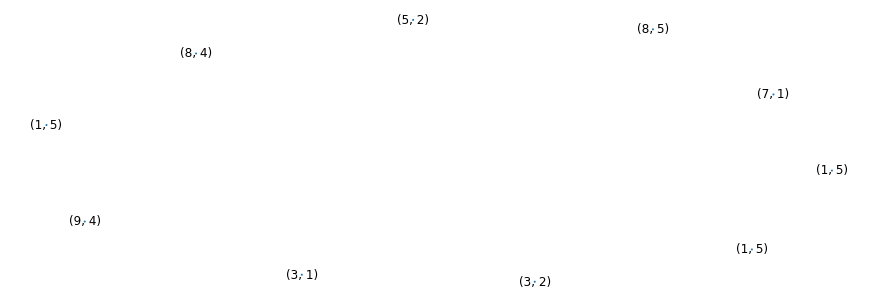

In [69]:
# starting state
plot_network(0)

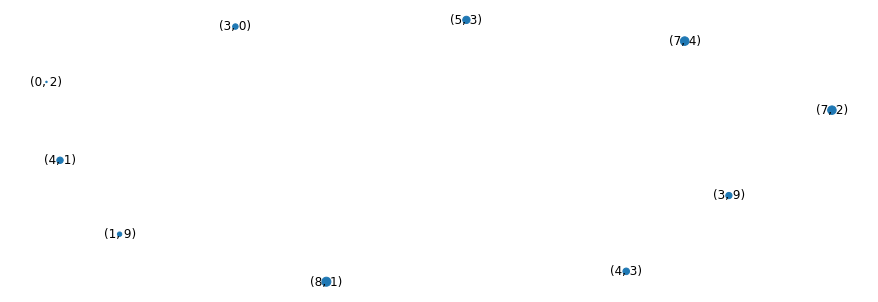

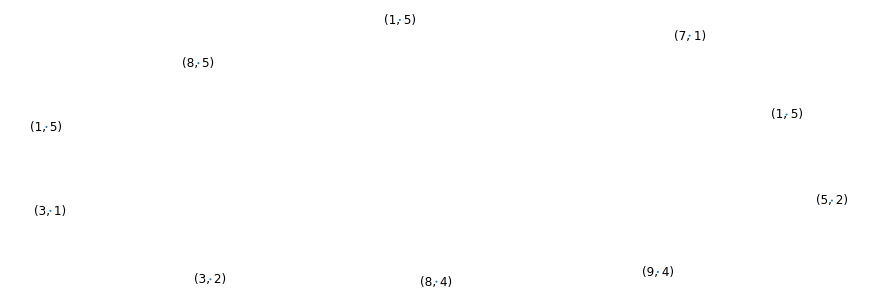

In [70]:
# last timestep
plot_network(-1)